# Imports

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import matplotlib

import base_style
sns.set_style("white", base_style.base_style)
sns.set_context("talk", font_scale=1.5)

%matplotlib inline

import globus_auth

# Define Helper Functions

In [271]:
def get_vectors(data, namespace="_"):
     for key in data:
        return (data[key]['content'].get(namespace+'#comp', None), 
                data[key]['content'].get(namespace+'#delta_e', None),
                data[key]['content'].get(namespace+'#energy_pa', None),
                data[key]['content'].get(namespace+'#volume_pa', None),
                data[key]['content'].get(namespace+'#magmom_pa', None),
                data[key]['content'].get(namespace+'#stability', None),
                data[key]['content'].get(namespace+'#bandgap',None)) 
    
def rolling_window(seq, window_size):
    it = iter(seq)
    win = [it.__next__() for cnt in range(window_size)] # First window
    yield win
    for e in it: # Subsequent windows
        win[:-1] = win[1:]
        win[-1] = e
        yield win
        
def composition_to_dict(composition):
    digits = [0]
    if composition is None:
        return None
    for i, char in enumerate(composition):
        if str(char).isdigit():
            digits.append(i)    
    
    tmp_dict = {}
    for cur_d, next_d in rolling_window(digits, 2):
        if cur_d == 0:
            cur_d = 0
        else: 
            cur_d = cur_d + 1
        
        atom = composition[cur_d:next_d]
        if atom not in tmp_dict:
            tmp_dict[atom] = int(composition[next_d])
        else:
            return "error in composition"
    return tmp_dict#test_str[cur_d:next_d]

def get_composition_vector(df):
    compositions = []
    for i,row in df.iterrows():
        if row['digit'] is not None:
            compositions.append(row['digit'])
    return compositions

def get_plot_color(property):
    if np.abs(property) == 0:
        return "white"
    else:
        return "blue"

# Authenticate Search Client
Uses a valid authentication token if it exists, redirects to web if not

In [272]:
client = globus_auth.login("https://datasearch.api.demo.globus.org/")

# Search for Data and Aggregate into a DataFrame

In [ ]:
params = {
        'q': "oqmd",
        'count': 1,
        'from': 0,
        'stats': True
    }
    
r = client.search(**params)

In [ ]:
print("Found %d results"%(r.data['gstats']['total']))
r.data

# Aggregate a Larger Query

In [273]:
n_records = 900
offset = 0
vectors = []

for i in range(0,10):
    params = { 'q': "OQMD",
               'count': n_records,
               'from': i*n_records}

    r = client.search(**params)
    result_iterator = r.data['gmeta']
    for result in result_iterator:
        vectors.append(get_vectors(result))

df_oqmd = pd.DataFrame(vectors, columns=["composition", "delta_e", 
                                    "energy_pa", "volume_pa", 
                                    "magmom_pa","stability", "bandgap"])

# Extract the composition as a dictionary for later use
df_oqmd['composition_dict'] = df_oqmd['composition'].apply(composition_to_dict)
df_oqmd.dropna(how="all", inplace=True)

In [274]:
print(len(df_oqmd))
df_oqmd.head()
df_oqmd = df_oqmd[df_oqmd.energy_pa < 5 ]

9000


# Visualize the Results 

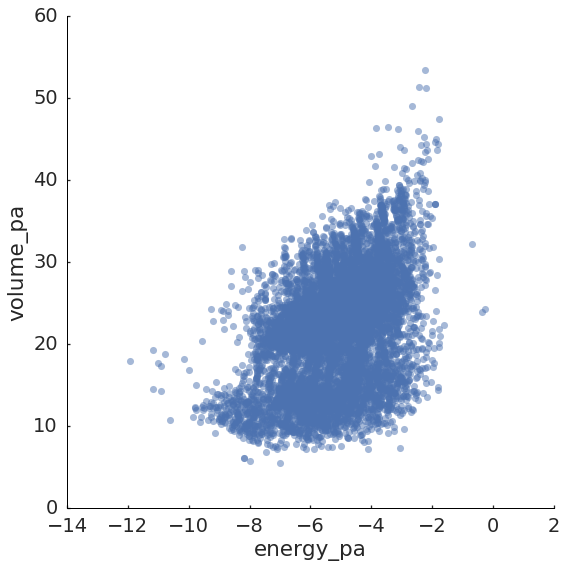

In [275]:
pal = sns.color_palette("muted")

x_col = "energy_pa"
y_col = "volume_pa"


# Make plot
g = sns.lmplot(x=x_col, y=y_col, data=df_oqmd, 
               fit_reg=False,
               palette=df_oqmd['bandgap'].apply(lambda x: get_plot_color(x)),
               size=8,
               scatter_kws={"s": 50, "alpha": 0.5})

# Set axis labels
g.set_axis_labels(x_col,y_col)

In [ ]:
plt.style.context('fivethirtyeight')
fig, ax = plt.subplots()

ax.scatter(df_oqmd[x_col], df_oqmd[y_col], s=30, 
           c=df_oqmd['bandgap'].apply(lambda x: get_plot_color(x)), 
           alpha=0.1 )
ax.set_xlabel("Energy/Atom")
ax.set_ylabel("Volume/Atom")
ax.set_xlim(-11,0)
ax.set_ylim(0,70)


sns.despine()

plt.show()

# JANAF Example
* http://kinetics.nist.gov/janaf/
* e.g., Search Na2

In [ ]:
n_records = 30
offset=10

vectors = []

for i in range(1):
    params = {
        'q': "JANAF",
        #'highlight': args.highlight,
        #'resource_type': args.resource_type,
        'count': n_records,
        'from': n_records*i+offset,
        #'stats': args.stats,
        #'facets': args.facets,
        #'filters': args.filters,
        #'boost': args.boost
    }
    
    janaf_vectors = []
    r = client.search(**params)
    for result in r.data['gmeta']:
        print(r.data['gmeta'])
        janaf_vectors.append(get_janaf_vector(result, 2))

df_janaf = pd.DataFrame(janaf_vectors, columns=["Composition", "Cp","T"])
composition,Cp,T = df_janaf.ix[1]
df_t = pd.DataFrame({"Cp":Cp, "T":T})

In [ ]:
r.data['gmeta']

In [ ]:
def get_janaf_vector(data, index, fields=['composition#comp',
                                          'http://kinetics.nist.gov/janaf#Cp',
                                          'http://kinetics.nist.gov/janaf#T']):
    result = []
    for key in data:
        for field in fields:
            result.append(data[key]['content'].get(field, None))

    return result

In [ ]:
df_janaf.head()

# Make Plot

In [ ]:
pal = sns.color_palette("muted")

g = sns.lmplot(x='T', y='Cp', data=df_t, fit_reg=False,
               palette=pal, size=8, scatter_kws={"s": 50, "alpha": 0.5})
g.ax.set_title('%s \n Max: %s | Min %s'%(composition, np.max(Cp), np.min(Cp)))

# ElectroCat Example

### Format the data as GMeta (there will be utilities to help with this)

In [261]:
client = globus_auth.login("https://datasearch.api.demo.globus.org/")

In [262]:
content1 = {
    "context":{
        "electrocat":"http://electrocat.org"
    },
    "electrocat#polarization": {
        "labels":["Output Voltage", "Power Density"],
        "units":["V","W cm-2"],
        "atmosphere":"O2",
        "pressure":{"value": 0.3, "unit":"bar"},
        "data":[
        [0.8991, 0.8997, 0.8554, 0.8057, 0.7555, 0.7055, 0.6561, 0.6059, 0.5561, 0.5059, 0.456, 0.4066, 0.3557, 0.3062, 0.2565, 0.2063],
        [8.97E-05, 8.99E-05, 7.37E-03, 0.034612872, 0.08866548, 0.1724242, 0.2788425, 0.38947252, 0.48781092, 0.5650903, 0.6173328, 0.63697956, 0.63328828, 0.61050156, 0.558657, 0.4852176]
        ]},
    "electrocat#keywords":["polarization curve", "electrocat"]
}

content2 = {
     "context":{
        "electrocat":"http://electrocat.org"
    },
    "electrocat#polarization": {
        "labels":["Output Voltage", "Power Density"],
        "units":["V","W cm-2"],
        "atmosphere":"O2",
        "pressure":{"value": 1.0, "unit":"bar"},
        "data":[
        [0.897,0.8961,0.8957,0.8523,0.8025,0.7523,0.7027,0.6527,0.6027,0.5527,0.5026,0.4522,0.403,0.3525,0.3029,0.2526,0.2031],
        [3.86E-04,3.84E-04,3.84E-04,0.022722318,0.0875688,0.20191732,0.34544732,0.49187472,0.62283018,0.72823752,0.8056678,0.85402492,0.872898,0.86151,0.8196474,0.7471908,0.6482952]
        ]},
    "electrocat#keywords":["polarization curve", "electrocat"]
}


###
# Don't worry about this, there would be helper functions for this
###
entry = {
                "@datatype":"GMetaEntry",
                "@version":"2016-11-09",
                "subject":"http://electrocat.org/api?electrocat-123",
                "visible_to":["public"],
                "id":"electrocat-123",
                "source_id":"electrocat",
                "content":content1
}

ingest = {
                "@datatype":"GIngest",
                "@version":"2016-11-09",
                "ingest_type":"GMetaList",
                "source_id":"electrocat",
                "ingest_data":{
                        "@datatype":"GMetaList",
                        "@version":"2016-11-09",
                        "gmeta":[entry]
                        }
                }

In [263]:
client.ingest(ingest)

GlobusHTTPResponse({'success': True})

In [267]:
params = {
        'q': "electrocat polarization",
        'count': 10,
        'from': 0,
        'stats': True
    }
    
r = client.search(**params)

In [268]:
r.data

{'gmeta': [{'http://electrocat.org/api?electrocat-124': {'content': {'_#context': {'_#electrocat': 'http://electrocat.org'},
     '_#electrocat#keywords': ['polarization curve', 'electrocat'],
     '_#electrocat#polarization': {'_#atmosphere': 'O2',
      '_#data': [[0.897,
        0.8961,
        0.8957,
        0.8523,
        0.8025,
        0.7523,
        0.7027,
        0.6527,
        0.6027,
        0.5527,
        0.5026,
        0.4522,
        0.403,
        0.3525,
        0.3029,
        0.2526,
        0.2031],
       [0.000386,
        0.000384,
        0.000384,
        0.022722318,
        0.0875688,
        0.20191732,
        0.34544732,
        0.49187472,
        0.62283018,
        0.72823752,
        0.8056678,
        0.85402492,
        0.872898,
        0.86151,
        0.8196474,
        0.7471908,
        0.6482952]],
      '_#labels': ['Output Voltage', 'Power Density'],
      '_#pressure': {'_#unit': 'bar', '_#value': 1.0},
      '_#units': ['V', 'W cm-2']

## Display the Data

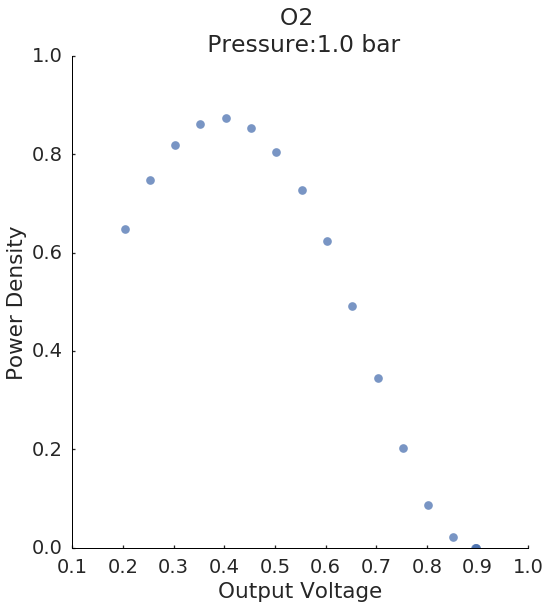

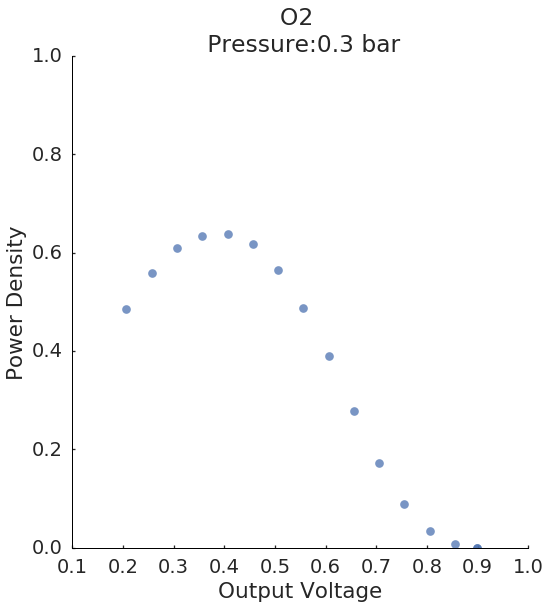

In [269]:
data = []
for result in r.data['gmeta']:
    for target in result:
        head = result[target]['content']['_#electrocat#polarization']
        df_ec = pd.DataFrame(head['_#data']).T
        df_ec.columns = [head['_#labels'][0], head['_#labels'][1]]
        
        pal = sns.color_palette("muted")
        g = sns.lmplot(x="Output Voltage", y="Power Density", data=df_ec,
                       fit_reg=False, palette=pal, size=8, 
                       scatter_kws={"s": 75, "alpha": 0.75})
        g.ax.set_title('%s \n Pressure:%s %s'%(head['_#atmosphere'], head['_#pressure']['_#value'], head['_#pressure']['_#unit']))
        g.ax.set_ylim(0,1)

## Set up Electrocat Community / Collections on UIUC Blue Waters
* Backups handled at UIUC - also backup to Argonne Petrel

## Data initially ACLd to Electrocat group

## Automating the flow with scripts --> data pub service and --> data search service

## Prototype a search interface that allows browsing of collections and datasets

## How to do this by October or December
